In [23]:
import sklearn
import tensorflow as tf
from tensorflow import keras
from matplotlib import pylab as plt
import numpy as np
# import matplotlib #don't delete!

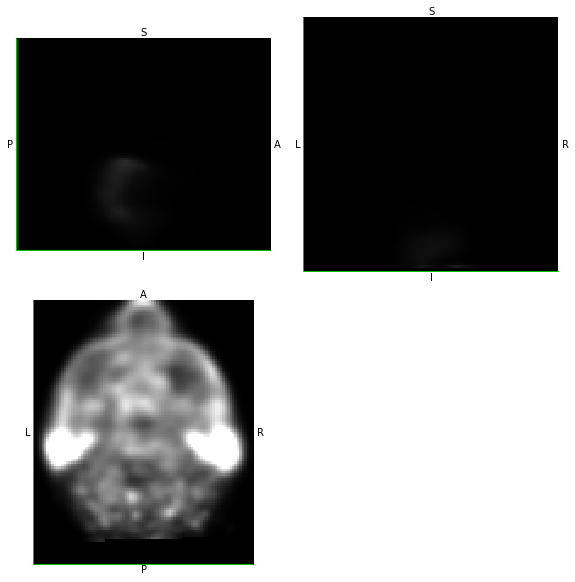

(91, 109, 91)

In [21]:
from matplotlib import pylab as plt
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
example_filename = "./datasets/A4/A4_aligned/B10018169/Florbetapir/cmeanA4_B10018169_MR_Florbetapir_Br_20200720182306561_S893044_I1321166.nii.gz"
 
img = nib.load(example_filename)
OrthoSlicer3D(img.dataobj).show()
fdata=img.get_fdata()
fdata.shape

In [37]:
from dataloader.A4 import A4Dataset_train,A4Dataset_test,load_data
from sklearn.model_selection import train_test_split,KFold

x,y=load_data("A4_PETVADATA_PRV2.csv","SCORE",400)
pre_fy=lambda y:1 if y=="positive" else 0
dataset=(x,y)
x_train,x_test,y_train,y_test=train_test_split(
    x,y,test_size=0.1,random_state=1919810
)
x_train,x_val,y_train,y_val=train_test_split(
    x_train,y_train,test_size=0.05,random_state=114514
)
train_d,val_d,test_d=(
    A4Dataset_train(x_train,y_train,ag_rate=4,batch_size=64,pre_fy=pre_fy),
    A4Dataset_test(x_val,y_val,batch_size=64,pre_fy=pre_fy),
    A4Dataset_test(x_test,y_test,batch_size=64,pre_fy=pre_fy)
)
print(len(x))

# kf = KFold(n_splits=10)

  9%|▉         | 408/4492 [00:00<00:09, 444.45it/s]

Total data number:400
unusable BID:['B11187381', 'B11238033', 'B11255389', 'B11941178', 'B14305912', 'B15852147', 'B16351784', 'B17815888']
400


In [19]:
from tensorflow.keras import callbacks
import time
from units.model import CNN3D

cb = [
    callbacks.ModelCheckpoint(
        filepath="checkpoints/ckpt-loss={loss:.2f}", save_freq=10000
    )
]
model=CNN3D()
model.fit(generator=train_d,epochs=30,callbacks=cb,validation_data=val_d)
model.save("./models/m{}.h5".format(time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())))
model.save("./models/latest.h5")

C:\Users\CH2\.conda\envs\mtf\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
 1/14 [=>............................] - ETA: 1:48 - loss: 1.1785 - sparse_categorical_accuracy: 0.2812

KeyboardInterrupt: 

In [ ]:
### advanced learn
from tensorflow.keras.models import load_model
model=load_model("./models/latest.h5")
model.fit(generator=train_d,epochs=30,callbacks=cb,validation_data=val_d)
model.save("./models/m{}.h5".format(time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())))
model.save("./models/latest.h5")

In [40]:
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model

model=load_model("./models/latest.h5")
y_testtruth=np.array([pre_fy(y)for y in y_test])
y_predit=model.predict(test_d)
tot=metrics.sparse_categorical_accuracy(y_testtruth,y_predit)
acc=sum(tot)/len(tot)
print("Test accuracy={}".format(acc.numpy()))


Test accuracy=0.8500000238418579


40

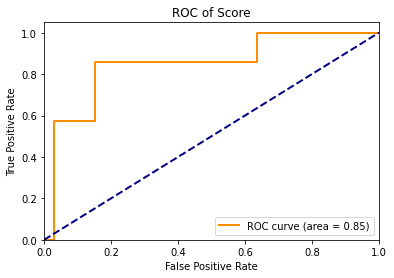

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp


# ylabel=label_binarize(y_testp,classes=[0,1])
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(2):
fpr, tpr, _ = roc_curve(y_testtruth, y_predit[:, 1])
roc_auc = auc(fpr, tpr)
# fpr[0].shape==tpr[0].shape==(21, ), fpr[1].shape==tpr[1].shape==(35, ), fpr[2].shape==tpr[2].shape==(33, ) 
# roc_auc {0: 0.9118165784832452, 1: 0.6029629629629629, 2: 0.7859477124183007}

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.title('ROC of Score')
plt.legend(loc="lower right")
plt.show()
